Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
!rm -rf /content/skin_cancer
!cp /content/drive/MyDrive/CNN_assignment.zip /content
!unzip /content/CNN_assignment.zip -d /content/skin_cancer

Archive:  /content/CNN_assignment.zip
  inflating: /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jp

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Test')


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

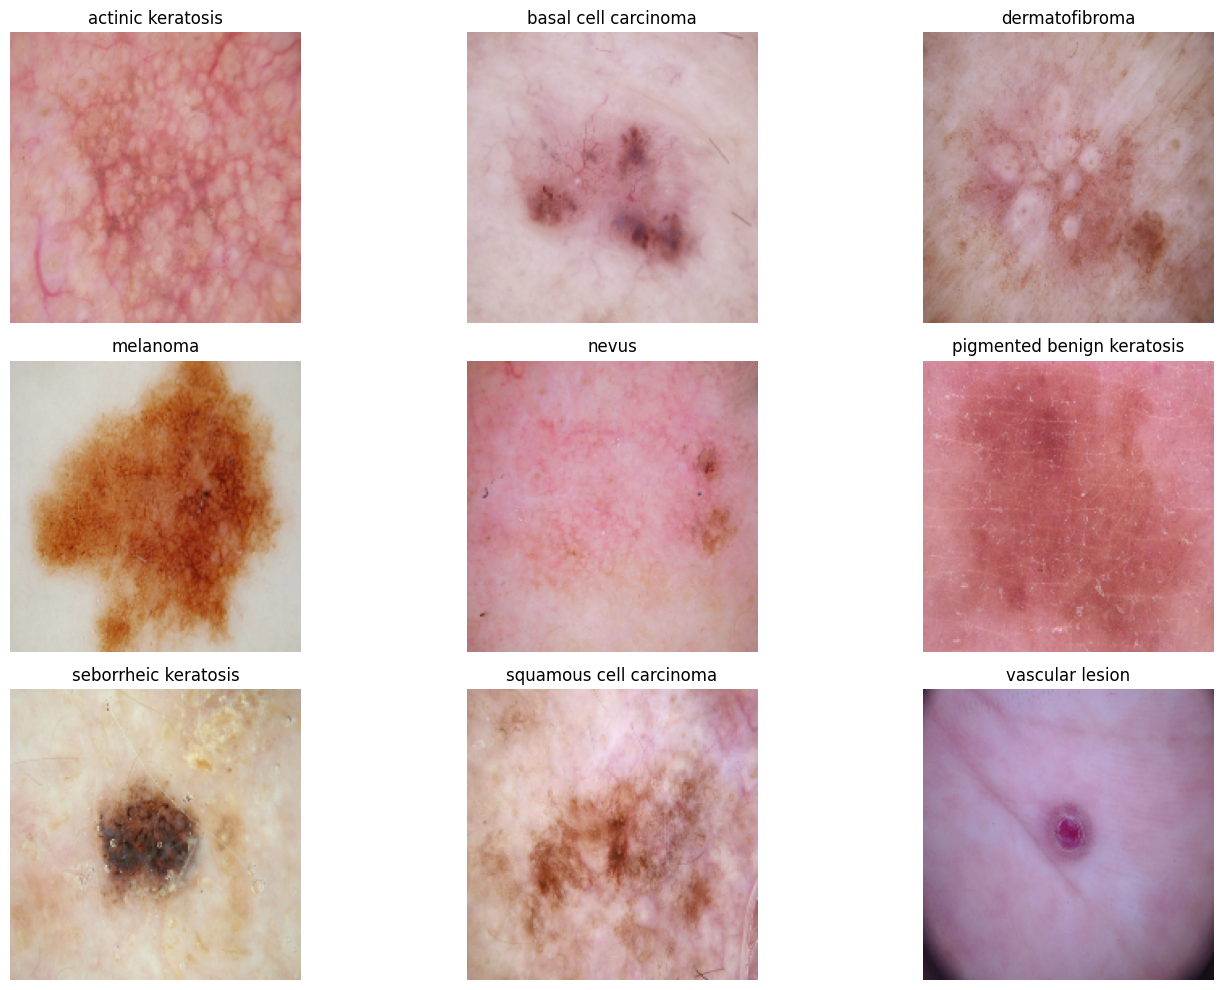

In [11]:
import matplotlib.pyplot as plt

imgs_smpl = {}

# Iterate through the dataset to collect one sample from each class
for imgs, lbls in train_ds:
    for i in range(len(lbls)):
        label_class = class_names[lbls[i]]
        if label_class not in imgs_smpl:
            imgs_smpl[label_class] = imgs[i].numpy().astype("uint8")
        if len(imgs_smpl) == len(class_names):  # Stop if we have one example from each class
            break
    if len(imgs_smpl) == len(class_names):
        break

# Visualize the images
plt.figure(figsize=(15, 10))

for idx, label_class in enumerate(class_names):
    plt.subplot(3, 3, idx + 1)  # Create a 3x3 grid for visualization
    plt.imshow(imgs_smpl[label_class])
    plt.title(label_class)
    plt.axis("off")

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
# Normalize the pixel values to [0, 1]
norm_layer = layers.Rescaling(1./255)

train_dataset = train_ds.map(lambda x, y: (norm_layer(x), y))
validation_dataset = val_ds.map(lambda x, y: (norm_layer(x), y))

model_1 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
epochs = 20
history_1 = model_1.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - accuracy: 0.1757 - loss: 2.0813 - val_accuracy: 0.2729 - val_loss: 1.9708
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2870 - loss: 1.9140 - val_accuracy: 0.4094 - val_loss: 1.6835
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3706 - loss: 1.7393 - val_accuracy: 0.3893 - val_loss: 1.6587
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.3926 - loss: 1.6958 - val_accuracy: 0.4586 - val_loss: 1.5530
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4346 - loss: 1.5753 - val_accuracy: 0.4720 - val_loss: 1.5168
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4359 - loss: 1.5671 - val_accuracy: 0.4474 - val_loss: 1.5842
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5018 - loss: 1.4604 - val_accuracy: 0.4944 - val_loss: 1.4731
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4784 - loss: 1.4199 - val_accuracy: 0.4787 -

### Visualizing training results

In [17]:
def display_training_res(history):
  accuracy = history.history['accuracy']
  validation_accuracy = history.history['val_accuracy']

  loss = history.history['loss']
  validation_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, accuracy, label='Training Accuracy')
  plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, validation_loss, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.show()

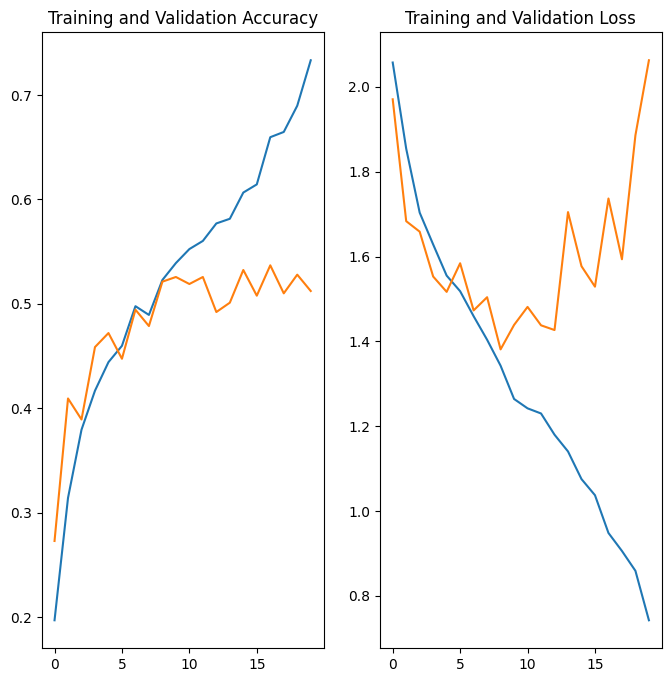

In [18]:
  display_training_res(history_1)

#### We can observe that the gap between the training accuracy plot and that of the validation accuracy is splitting wide open. Similarly with loss as well.This is a clear sign of overfitting. Let us create a newer model which can handle the overfitting.

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

augmented_train_dataset = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

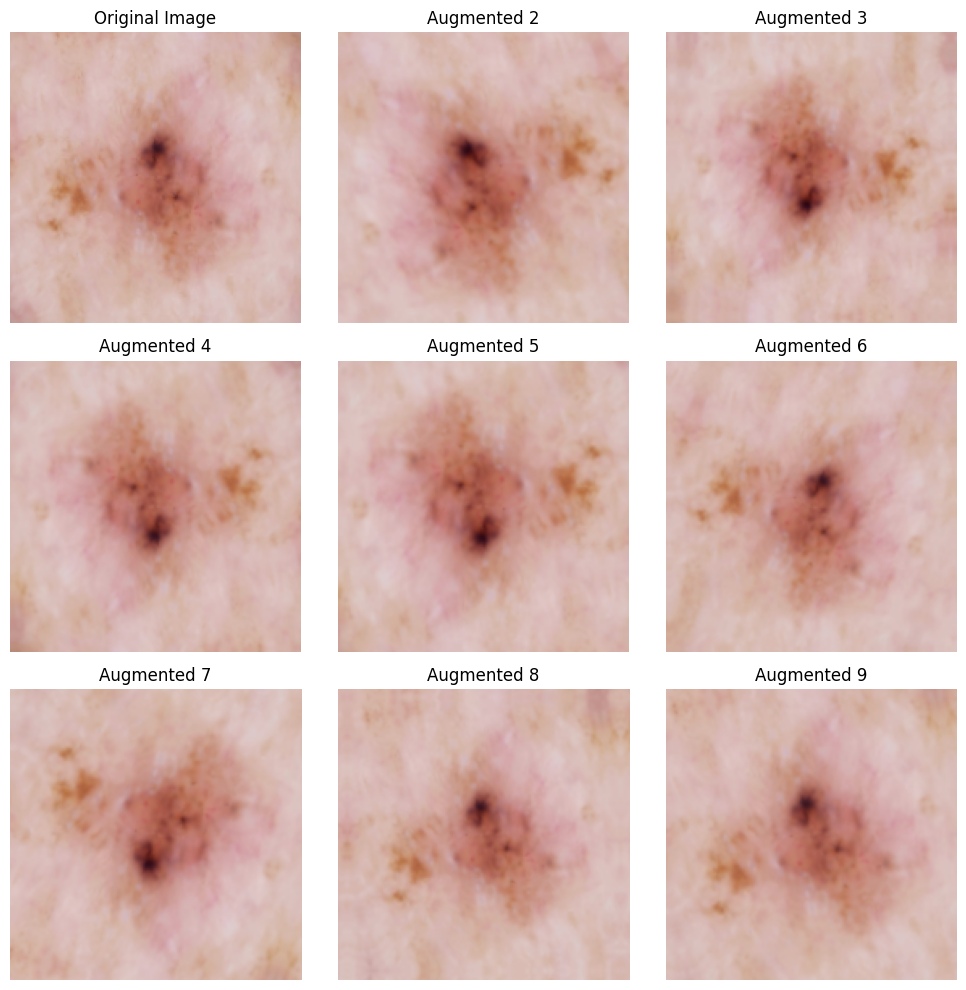

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
# Get one batch of images # Take the first image from the batch

def aug_vis(image):
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("Original Image")
    plt.axis("off")
    for i in range(2, 10):
        aug_img = data_augmentation(tf.expand_dims(image, 0), training=True)
        plt.subplot(3, 3, i)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(f"Augmented {i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

for images, labels in augmented_train_dataset.take(1):
  sample_image = images[0]
  aug_vis(sample_image)


### Create the model, compile and train the model


In [21]:
norm_layer = layers.Rescaling(1./255)

train_dataset = augmented_train_dataset.map(lambda x, y: (norm_layer(x), y))
validation_dataset = val_ds.map(lambda x, y: (norm_layer(x), y))

model_2 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])


### Compiling the model

In [22]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [23]:
epochs = 20
histor2 = model_2.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 304ms/step - accuracy: 0.1762 - loss: 2.4183 - val_accuracy: 0.2058 - val_loss: 2.1404
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.1840 - loss: 2.0297 - val_accuracy: 0.3020 - val_loss: 1.9687
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - accuracy: 0.3284 - loss: 1.8361 - val_accuracy: 0.4004 - val_loss: 1.8895
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.3638 - loss: 1.7541 - val_accuracy: 0.4116 - val_loss: 1.6550
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 0.3832 - loss: 1.7140 - val_accuracy: 0.4430 - val_loss: 1.6247
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 293ms/step - accuracy: 0.4085 - loss: 1.6085 - val_accuracy: 0.3848 - val_loss: 1.7345
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - accuracy: 0.4013 - loss: 1.6362 - val_accuracy: 0.4183 - val_loss: 1.6041
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.4424 - loss: 1.5533 - val_accu

### Visualizing the results

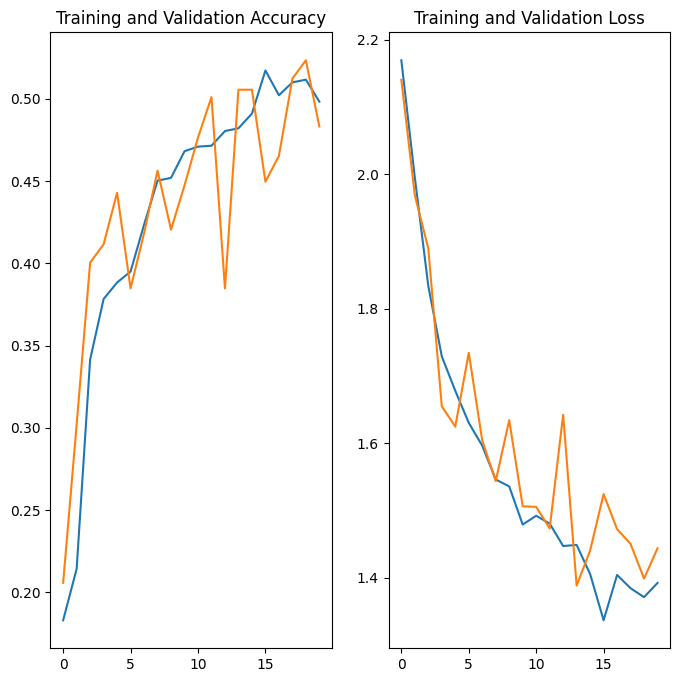

In [24]:
display_training_res(histor2)

#### IN the above model we can observe that the model training accuracy and validation accuracy are going in the similar direction rather than splitting apart. Similar is the trend with the validation and training loss. This shows that the model is not overfitting or underfitting.

#### Find the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

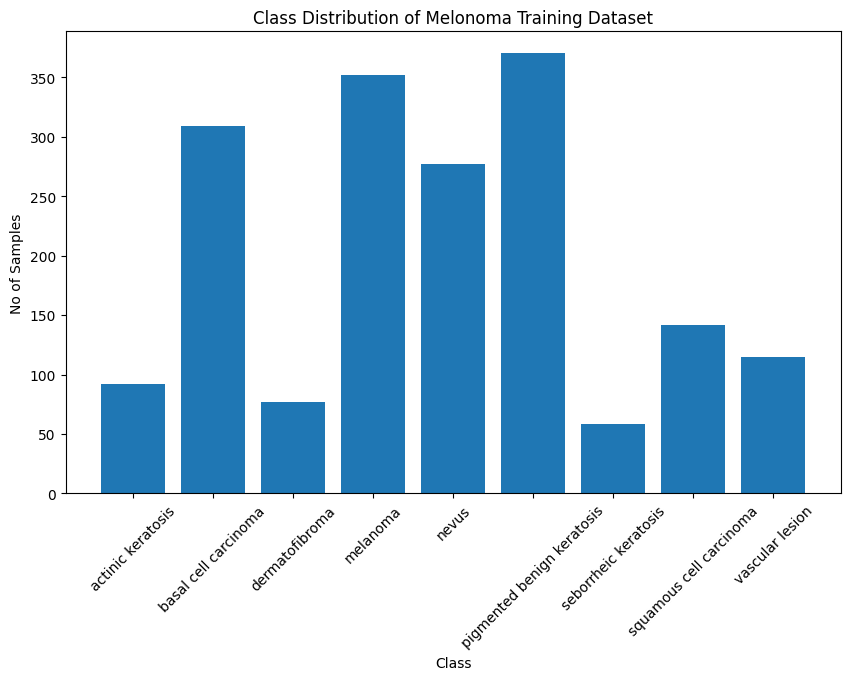

In [25]:
## Your code goes here.
class_counts = np.zeros(len(class_names))

for _, labels in train_ds:
    for label in labels:
        class_counts[label] += 1

plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Class')
plt.ylabel('No of Samples')
plt.title('Class Distribution of Melonoma Training Dataset')
plt.xticks(rotation=45)
plt.show()

#### **Class that has the least number of samples** = Seborrheic Keratosis
#### **Class that has the most number of samples** = Pigmented Benign Keratosis
     
#### **Which classes dominate the data in terms proportionate number of samples?** = Basal Cell Carcinoma, Melanoma, Nevus, Pigmented Benign Keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98BE2E2470>: 100%|██████████| 500/500 [00:19<00:00, 26.06 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98BE08BEE0>: 100%|██████████| 500/500 [00:19<00:00, 25.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F98BE0BF5E0>: 100%|██████████| 500/500 [00:19<00:00, 25.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F993DB4D330>: 100%|██████████| 500/500 [01:25<00:00,  5.84 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F993DBAB670>: 100%|██████████| 500/500 [01:12<00:00,  6.87 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98E2100820>: 100%|██████████| 500/500 [00:15<00:00, 31.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F98BE273CD0>: 100%|██████████| 500/500 [00:40<00:00, 12.29 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F993DB4D330>: 100%|██████████| 500/500 [00:14<00:00, 33.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F993DBAB670>: 100%|██████████| 500/500 [00:15<00:00, 32.71 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
from pathlib import Path
train_data_Dir_path = Path("/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
image_count_train = len(list(train_data_Dir_path.glob("*/output/*.jpg")))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
from glob import glob

In [30]:
path_list = [x for x in glob(os.path.join(train_data_Dir_path, '*','output', '*.jpg'))]
path_list

['/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0027665.jpg_b9e56611-f23c-430f-96cc-f5731ae954b6.jpg',
 '/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033092.jpg_6f313888-0e42-414b-9234-2ba0e0771598.jpg',
 '/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0025924.jpg_d05f7cd6-cfea-4123-b485-f68f60b8dd7b.jpg',
 '/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0034196.jpg_4e78ab15-23cb-4e34-ae0c-b9311baa81b4.jpg',
 '/content/skin_cancer/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0031103.jpg_94ed5ce6-ff96-4387-bb4f-e2954ea563fc.jpg',
 '/co

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_data_Dir_path, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [32]:
len(lesion_list_new)

4500

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [34]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_Dir_path,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_Dir_path,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [36]:
## your code goes here
norm_layer = layers.Rescaling(1./255)
train_dataset = train_ds.map(lambda x, y: (norm_layer(x), y))
validation_dataset = val_ds.map(lambda x, y: (norm_layer(x), y))

model_3 = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])


#### Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model_3_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="model/model_3.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train your model

In [38]:
epochs = 30
history_3 = model_3.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks = [
      model_3_checkpoint_callback,
      keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)]
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 251ms/step - accuracy: 0.1360 - loss: 2.2453 - val_accuracy: 0.2272 - val_loss: 2.0192
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 28s 164ms/step - accuracy: 0.2317 - loss: 1.9755 - val_accuracy: 0.3378 - val_loss: 1.7543
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - accuracy: 0.3531 - loss: 1.6937 - val_accuracy: 0.4187 - val_loss: 1.5260
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.4200 - loss: 1.5136 - val_accuracy: 0.4439 - val_loss: 1.4363
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - accuracy: 0.4360 - loss: 1.4659 - val_accuracy: 0.4736 - val_loss: 1.3587
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.4787 - loss: 1.3485 - val_accuracy: 0.5063 - val_loss: 1.2765
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 158ms/step - accuracy: 0.5025 - loss: 1.2901 - val_accuracy: 0.5353 - val_loss: 1.2368
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.5524 - loss: 1

#### **Todo:**  Visualize the model results

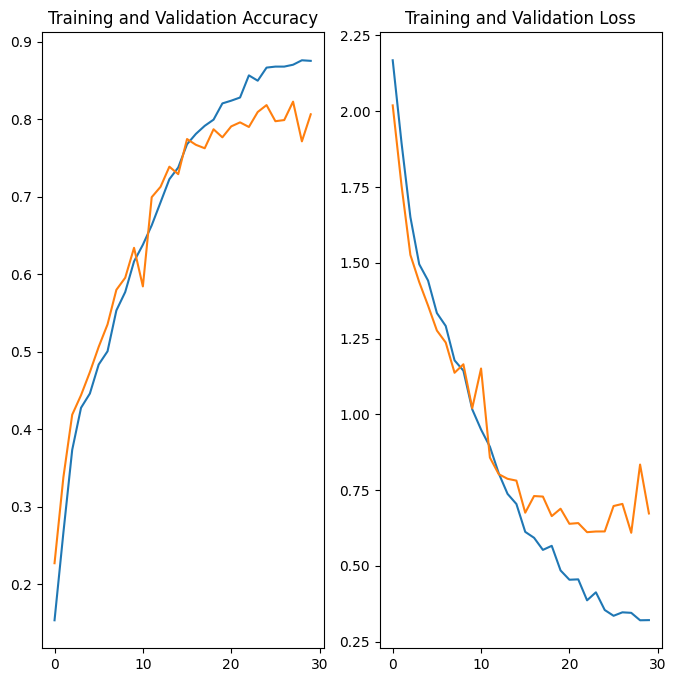

In [39]:
display_training_res(history_3)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The class rebalancing helped in improving the accuracy and also reduced the overfitting in the model.

### Check the model on Test dataset

In [40]:
# Loading the test dataset
test_dataset_to_be_tested = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    image_size=(img_height, img_width),
    batch_size=32,
    shuffle=False
)

Found 118 files belonging to 9 classes.


In [41]:
test_loss, test_accuracy = model_3.evaluate(test_dataset_to_be_tested)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.2988 - loss: 526.4662


In [42]:
print(f"Test Loss is {test_loss}")
print(f"Test Accuracy is {test_accuracy}")

Test Loss is 587.43212890625
Test Accuracy is 0.26271185278892517


In [43]:
import numpy as np

preds = model_3.predict(test_dataset_to_be_tested)
pred_classes = np.argmax(preds, axis=1)
true_lbls = np.concatenate([y for x, y in test_dataset_to_be_tested], axis=0)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 940ms/step


In [44]:
from sklearn.metrics import classification_report
class_report = classification_report(true_lbls, pred_classes, target_names=test_dataset_to_be_tested.class_names)
print(class_report)

                            precision    recall  f1-score   support

         actinic keratosis       0.18      0.12      0.15        16
      basal cell carcinoma       0.26      0.62      0.37        16
            dermatofibroma       0.38      0.19      0.25        16
                  melanoma       0.19      0.31      0.24        16
                     nevus       0.67      0.25      0.36        16
pigmented benign keratosis       0.19      0.19      0.19        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.27      0.19      0.22        16
           vascular lesion       1.00      0.33      0.50         3

                  accuracy                           0.26       118
                 macro avg       0.35      0.25      0.25       118
              weighted avg       0.32      0.26      0.25       118



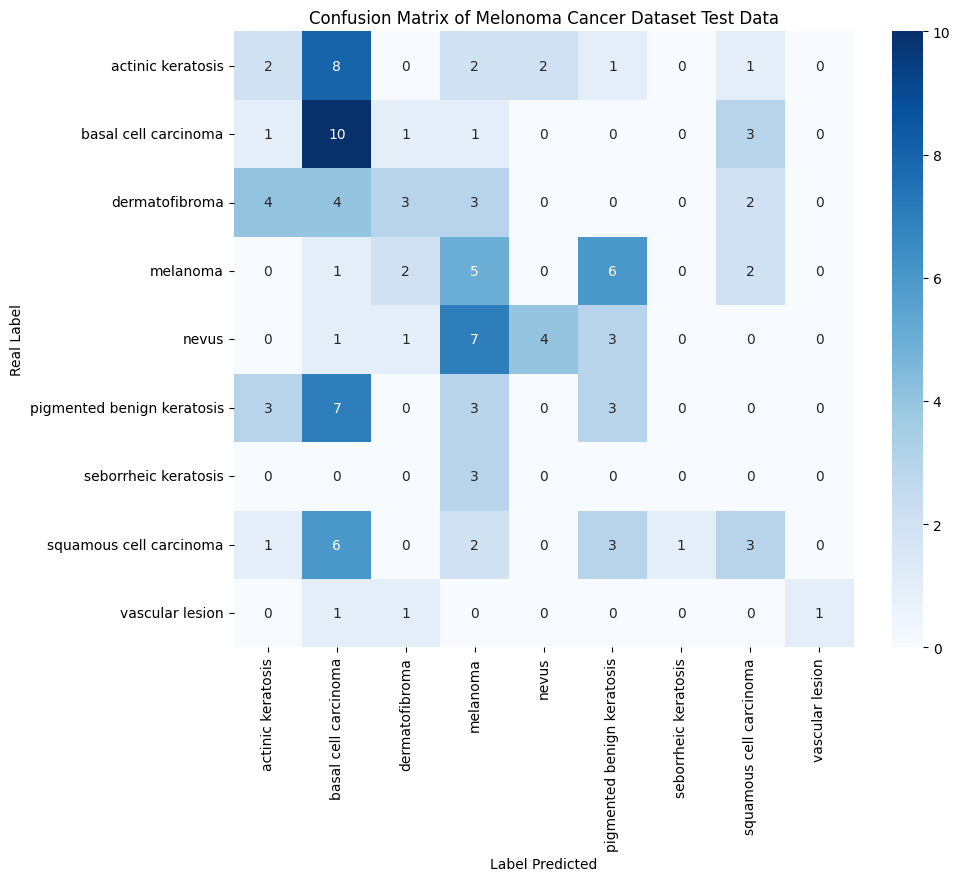

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(true_lbls, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset_to_be_tested.class_names, yticklabels=test_dataset_to_be_tested.class_names)
plt.xlabel('Label Predicted')
plt.ylabel('Real Label')
plt.title('Confusion Matrix of Melonoma Cancer Dataset Test Data')
plt.show()